##### Copyright 2024 Google LLC.

In [2]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# What's new in Gemini-1.5-pro-002 and Gemini-1.5-flash-002

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/New_in_002.ipynb"><img src="../images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>


This notebook explores the new options added with the 002 versions of the 1.5 series models:

* Candidate count
* Presence and frequency penalties
* Response logprobs

## Setup

Install a `002` compatible version of the SDK:

In [ ]:
!pip install -q "google-generativeai>=0.8.2"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 760.0/760.0 kB 11.8 MB/s eta 0:00:00


import the package and give it your API-key

In [2]:
import google.generativeai as genai

In [ ]:
from google.colab import userdata
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

Import other packages.

In [3]:
from IPython.display import display, Markdown, HTML

Check available 002 models

In [4]:
for model in genai.list_models():
  if '002' in model.name:
    print(model.name)

models/gemini-1.5-pro-002
models/gemini-1.5-flash-002


In [5]:
model_name = "models/gemini-1.5-flash-002"
test_prompt="Why don't people have tails"

## Quick refresher on `generation_config` [Optional]

In [9]:
model = genai.GenerativeModel(model_name, generation_config={'temperature':1.0})
response = model.generate_content('hello', generation_config = genai.GenerationConfig(max_output_tokens=5))

Note:

* Each `generate_content` request is sent with a `generation_config` (`chat.send_message` uses `generate_content`).
* You can set the `generation_config` by either passing it to the model's initializer, or passing it in the arguments to `generate_content` (or `chat.send_message`).
* Any `generation_config` attributes set in `generate_content` override the attributes set on the model.
* You can pass the `generation_config` as either a Python `dict`, or a `genai.GenerationConfig`.
* If you're ever unsure about the parameters of `generation_config` check `genai.GenerationConfig`.

## Candidate count

With 002 models you can now use `candidate_count > 1`.

In [ ]:
model = genai.GenerativeModel(model_name)

In [ ]:
generation_config = dict(candidate_count=2)

In [ ]:
response = model.generate_content(test_prompt, generation_config=generation_config)

But note that the `.text` quick-accessor only works for the simple 1-candidate case.

In [ ]:
try:
  response.text # Fails with multiple candidates, sorry!
except ValueError as e:
  print(e)

Invalid operation: The `response.parts` quick accessor retrieves the parts for a single candidate. This response contains multiple candidates, please use `result.candidates[index].text`.


With multiple candidates you have to handle the list of candidates yourself:

In [ ]:
for candidate in response.candidates:
  display(Markdown(candidate.content.parts[0].text))
  display(Markdown("-------------"))


Humans don't have tails because of evolution.  Our ancestors, primates like apes and monkeys, *did* have tails, but over millions of years of evolution, the tail gradually disappeared.  The exact reasons are complex and not fully understood, but several contributing factors are likely:

* **Loss of function:**  As our ancestors adapted to arboreal (tree-dwelling) life and then to bipedalism (walking upright), the need for a tail for balance and locomotion decreased.  Tails are primarily used for balance and climbing;  our hands and upright posture made a tail less essential.

* **Natural selection:** Individuals with shorter tails or rudimentary tails might have had a slight survival advantage. Perhaps shorter tails were less cumbersome while climbing, less likely to be injured, or offered less drag while running.  Over generations, these small advantages led to the selection and propagation of genes that resulted in shorter and shorter tails.  Eventually, the genes responsible for tail development became suppressed.

* **Genetic mutations:**  Genetic mutations that impacted tail development could have occurred randomly. Some of these mutations may have provided advantages that were selected for, while others may have been neutral and simply became fixed in the population over time.

It's important to note that the complete loss of a tail wasn't a sudden event. It was a gradual process taking place over a very long evolutionary timescale.  We still retain some vestigial remnants of a tail in the coccyx (tailbone), which is a small, fused bone at the base of the spine.  This provides a structural support for our pelvis but is the only physical evidence of what was once a functional tail.


-------------

Humans don't have tails because of evolution.  Our ancestors had tails, but over millions of years, the genes that controlled tail development were suppressed.  There are a few theories about why this happened:

* **Loss of function:**  The tail may have become less advantageous.  While useful for balance and communication in arboreal primates, as our ancestors transitioned to walking upright and relied less on climbing, the tail's utility decreased.  The energy and resources used to maintain a tail became a disadvantage, so individuals with smaller tails or no tails had a slight evolutionary advantage.  Natural selection favored individuals with mutations that progressively reduced tail size.

* **Developmental changes:** Changes in the genes controlling embryonic development led to the shortening of the tail during human development. The tail's reduction may have been a consequence of changes in other aspects of our anatomy and development, such as changes to the spine and pelvis related to bipedalism.

* **Genetic mutations:** Random genetic mutations that affected tail development could have spread through the population if they conferred even a slight advantage or were neutral in their effect.

Essentially, the tail became a vestigial structure – a feature that has lost most or all of its original function through evolution.  While we don't have external tails, we do retain a vestigial tailbone (coccyx) at the base of our spine, which is evidence of our tailed ancestry.


-------------

The response contains multiple full `Candidate` objects.

In [ ]:
response

response:
GenerateContentResponse(
    done=True,
    iterator=None,
    result=protos.GenerateContentResponse({
      "candidates": [
        {
          "content": {
            "parts": [
              {
                "text": "Humans don't have tails because of evolution.  Our ancestors, primates like apes and monkeys, *did* have tails, but over millions of years of evolution, the tail gradually disappeared.  The exact reasons are complex and not fully understood, but several contributing factors are likely:\n\n* **Loss of function:**  As our ancestors adapted to arboreal (tree-dwelling) life and then to bipedalism (walking upright), the need for a tail for balance and locomotion decreased.  Tails are primarily used for balance and climbing;  our hands and upright posture made a tail less essential.\n\n* **Natural selection:** Individuals with shorter tails or rudimentary tails might have had a slight survival advantage. Perhaps shorter tails were less cumbersome while climbing, l

## Penalties

The `002` models expose `penalty` arguments that let you affect the statistics of output tokens.

### Presence penalty

The `presence_penalty` penalizes tokens that have already been used in the output, so it induces variety in the model's output. This is detectible if you count the unique words in the output.

Here's a function to run a prompt a few times and report the fraction of unique words (words don't map perfectly to tokens but it's a simple way to see the effect).

In [ ]:
from statistics import mean

In [ ]:
def unique_words(prompt, generation_config, N=10):
  responses = []
  vocab_fractions = []
  for n in range(N):
    model = genai.GenerativeModel(model_name)
    response = model.generate_content(contents=prompt, generation_config=generation_config)
    responses.append(response)

    words = response.text.lower().split()
    score = len(set(words))/len(words)
    print(score)
    vocab_fractions.append(score)

  return vocab_fractions

In [ ]:
prompt='Tell me a story'

In [ ]:
# baseline
v = unique_words(prompt, generation_config={})

0.6282973621103117
0.58298755186722
0.5496957403651116
0.6046511627906976
0.5792207792207792
0.5846867749419954
0.6169154228855721
0.5696821515892421
0.6074766355140186
0.5928571428571429


In [ ]:
mean(v)

0.5916470724142091

In [ ]:
# the penalty encourages diversity in the oputput tokens.
v = unique_words(prompt, generation_config=dict(presence_penalty=1.999))

0.579088471849866
0.5753968253968254
0.6073903002309469
0.5909090909090909
0.6294277929155313
0.6056644880174292
0.5906313645621182
0.5844748858447488
0.6439232409381663
0.6247288503253796


In [ ]:
mean(v)

0.6031635310990102

In [ ]:
# a negative penalty discourages diversity in the output tokens.
v = unique_words(prompt, generation_config=dict(presence_penalty=-1.999))

0.6129032258064516
0.5924170616113744
0.5538461538461539
0.5723981900452488
0.5979166666666667
0.5841836734693877
0.6076923076923076
0.5763097949886105
0.5939849624060151
0.5878524945770065


In [ ]:
mean(v)

0.5879504531109223

The `presence_penalty` has a small effect on the vocabulary statistics.

### Frequency Penalty

Frequency penalty is similar to the `presence_penalty` but  the penalty is multiplied by the number of times a token is used. This effect is much stronger than the `presence_penalty`.

The easiest way to see that it works is to ask the model to do something repetitive. The model has to get creative while trying to complete the task.

In [ ]:
model = genai.GenerativeModel(model_name)
response = model.generate_content(contents='please repeat "Cat" 50 times, 10 per line',
                                  generation_config=dict(frequency_penalty=1.999))

In [ ]:
print(response.text)

Cat Cat Cat Cat Cat Cat Cat Cat Cat
Cat Cat Cat Cat Cat Cat Cat Cat
Cat
Cat  Cat  Cat  Cat  Cat  Cat   C at C at
Cat Cat Cat Cat Cat Cat  Cat   Cat
Cat



Since the frequency penalty accumulates with usage, it can have a much stronger effect on the output compared to the presence penalty.

> Caution: Be careful with negative frequency penalties: A negative penalty makes a token more likely the more it's used. This positive feedback quickly leads the model to just repeat a common token until it hits the `max_output_tokens` limit (once it starts the model can't produce the `<STOP>` token).

In [ ]:
response = model.generate_content(
    prompt,
    generation_config=genai.GenerationConfig(
        max_output_tokens=400,
        frequency_penalty=-2.0))

In [ ]:
Markdown(response.text)  # the, the, the, ...

Elara, a clockmaker with hands stained the perpetual sepia of old gears, lived in a town perpetually shrouded in twilight.  Not a twilight of gloom, but a soft, ethereal half-light, where the sun hung eternally low, casting long, dancing shadows. The townsfolk, accustomed to this perpetual dusk, measured time not by the sun, but by the intricate clocks Elara crafted.

Each clock was unique, a miniature universe housed in glass and brass.  One, shaped like a hummingbird, chirped the hours. Another, a miniature, swirling galaxy, displayed the phases of the moon.  Elara poured her soul into these creations, her life a delicate balance of gears and springs, as precise and predictable as her clocks, yet as mysterious as the twilight that enveloped her town.

One day, a young, freckled boy named Finn arrived, his eyes bright with wonder. He'd journeyed from a sun-drenched land, a place Elara had only heard whispered tales of – a place where the sun blazed high and shadows were short and sharp. Finn carried with him a small, broken sundial, its gnomon snapped, its face cracked.

Elara, captivated by Finn's story, took the sundial, its broken, sun-scorched face a stark contrast to her own creations. As she carefully repaired it, she found herself drawn to the simplicity of the sundial, the raw, unadorned way it measured the passage of time, unlike the ornate, meticulously crafted clocks of the twilight town.

While the sundial mended the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the

In [ ]:
response.candidates[0].finish_reason

<FinishReason.MAX_TOKENS: 2>

## Response logprobs

### Basics

If you set the `response_logprobs` config parameter to `True` the API will return the `log_probability` of each token.

In [ ]:
model = genai.GenerativeModel(model_name)
test_prompt="Why don't people have tails?"

response = model.generate_content(
    test_prompt,
    generation_config=dict(response_logprobs=True,)
)

Here are the first 10:

In [ ]:
response.candidates[0].logprobs_result.chosen_candidates[:10]

[token: "Humans"
 log_probability: -1.4543589713866822e-05,
 token: " don"
 log_probability: -0.0026181568391621113,
 token: "\'"
 log_probability: -2.3844768293201923e-07,
 token: "t"
 log_probability: 0.0,
 token: " have"
 log_probability: -3.576059555143729e-07,
 token: " tails"
 log_probability: -0.00011789497511927038,
 token: " because"
 log_probability: -0.02218734472990036,
 token: " of"
 log_probability: -0.008214056491851807,
 token: " evolutionary"
 log_probability: -0.7429894208908081,
 token: " changes"
 log_probability: -0.00029677830752916634]

This value is normalized so `math.exp(logrob)` returns a probability (they would sum to 1.0 if you had the logprobs for all the token candidates). Most tokens are high probability, but a few are less than 5%.

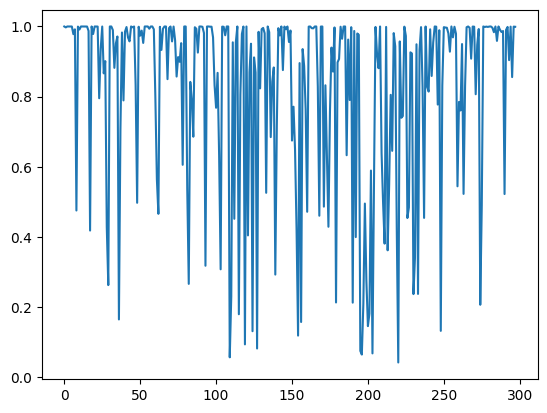

In [ ]:
import matplotlib.pyplot as plt
import math

plt.plot([math.exp(cc.log_probability) for cc in response.candidates[0].logprobs_result.chosen_candidates])

For fun, print the text, with the words colored based on their probabilities: Grey for the words that were >95%, and red for the words that were <5%.

In [ ]:
def color_text(response):
  md = []
  for cc in response.candidates[0].logprobs_result.chosen_candidates:
    prob = math.exp(cc.log_probability)
    token = cc.token

    if token.startswith(' '):
      token = token[1:]
      prefix = ' '
    else:
      prefix = ''

    if prob < 0.05:
      md.append(f"{prefix}<span style=\"color:red\">{token}</span>")
    elif prob > 0.95:
      md.append(f"{prefix}<span style=\"color:grey\">{token}</span>")
    else:
      md.append(f"{prefix}{token}")

  return HTML(''.join(md))

In [ ]:
color_text(response)

### `logprobs` count

Just enabling the `response_logprobs` gives you the probability for the chosen word. The API also exposes a `logprobs` argument which lets you set the number of top candidate token logprobs to also return.

In [ ]:
model = genai.GenerativeModel(model_name)
test_prompt="Why don't people have tails?"

response = model.generate_content(
    test_prompt,
    generation_config=dict(response_logprobs=True, logprobs=5)
)

In [ ]:
color_text(response)

You can see that for this example `Humans` has an extremely high probability of being the first word (`log(0) == 1.0`):

In [ ]:
response.candidates[0].logprobs_result.top_candidates[0]

candidates {
  token: "Humans"
  log_probability: -1.4543589713866822e-05
}
candidates {
  token: "Human"
  log_probability: -11.750014305114746
}
candidates {
  token: "The"
  log_probability: -12.125014305114746
}
candidates {
  token: "We"
  log_probability: -13.812514305114746
}
candidates {
  token: "While"
  log_probability: -16.218765258789062
}

But you can check the probabilities anywhere.

In [ ]:
def print_choices_at(index):
  remainder = 1.0
  lpr = response.candidates[0].logprobs_result
  print('Top choices:')
  for can in lpr.top_candidates[index].candidates:
    prob = math.exp(can.log_probability)
    remainder -= prob
    print(f"    {can.token:<20s}", f"{prob:0.12f}")

  print('---')
  print(f"{'remainder':<20s}", f"{remainder:0.12f}")
  print('---')
  chose = lpr.chosen_candidates[index].token
  chose_prob = math.exp(lpr.chosen_candidates[index].log_probability)
  print(f"{'chose: '+chose:<20s}", f"{chose_prob:0.12f}")

In [ ]:
print_choices_at(0)

Top choices
    Humans               0.999985456516
    Human                0.000007889212
    The                  0.000005422171
    We                   0.000001003001
    While                0.000000090423
---
remainder            0.000000138677
---
chose: Humans        0.999985456516


For example, look at the choices at the first chosen token that had a <5% probability:

In [ ]:
less_than_5pct = [
    math.exp(cc.log_probability)<0.05
    for cc in response.candidates[0].logprobs_result.chosen_candidates]

surprising_index = less_than_5pct.index(True) # Find the index of the first True

In [ ]:
print_choices_at(surprising_index)

Top choices
     offered             0.645036407196
     conferred           0.229378848871
     provided            0.074290232874
     been                0.031575726210
     had                 0.018877649357
---
remainder            0.000841135492
---
chose:  been         0.031575726210
